In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import f1_score

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# 메모리를 최대한 사용하는 batch_size 설정
batch_size = 256

trainset = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True,
                                        download=True, 
                                        transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=4)

Files already downloaded and verified


In [6]:
# 모델 정의
## Q. pretrained : 학습된 데이터셋이 우리가 사용하려는 데이터 셋과 다르다면 
## 효과가 없지 않은가?
model = torchvision.models.resnet50(pretrained=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

cuda:0


In [7]:
# 4. 학습용 데이터를 사용하여 신경망 학습

epochs = 2
loss_ = []
accus = []
val_loss_list = []
val_accuracy_list = []

for epoch in range(epochs):

    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    # batch_size만큼 불러온 데이터 128개 배열 img
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        # cuda(gpu)로 데이터를 넘겨줘야 한다.
        inputs, labels = data[0].to(device), data[1].to(device)

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = model(inputs)
        # 손실 함수의 loss 결과 값을 그래프로 보면 될 것
        # batch마다 출력하고 있으니 epoch 끝날 때 마다 평균내서 출력해야 한다.
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()  
        
        # accuracy 계산
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        
    loss_.append(running_loss / i)
    accus.append(correct_predictions / total_predictions)
    print(f"[{epoch + 1}] loss: {running_loss / i:.3f} - accuracy: {correct_predictions / total_predictions:.3f}")





[1] loss: 0.947 - accuracy: 0.714
[2] loss: 0.447 - accuracy: 0.848


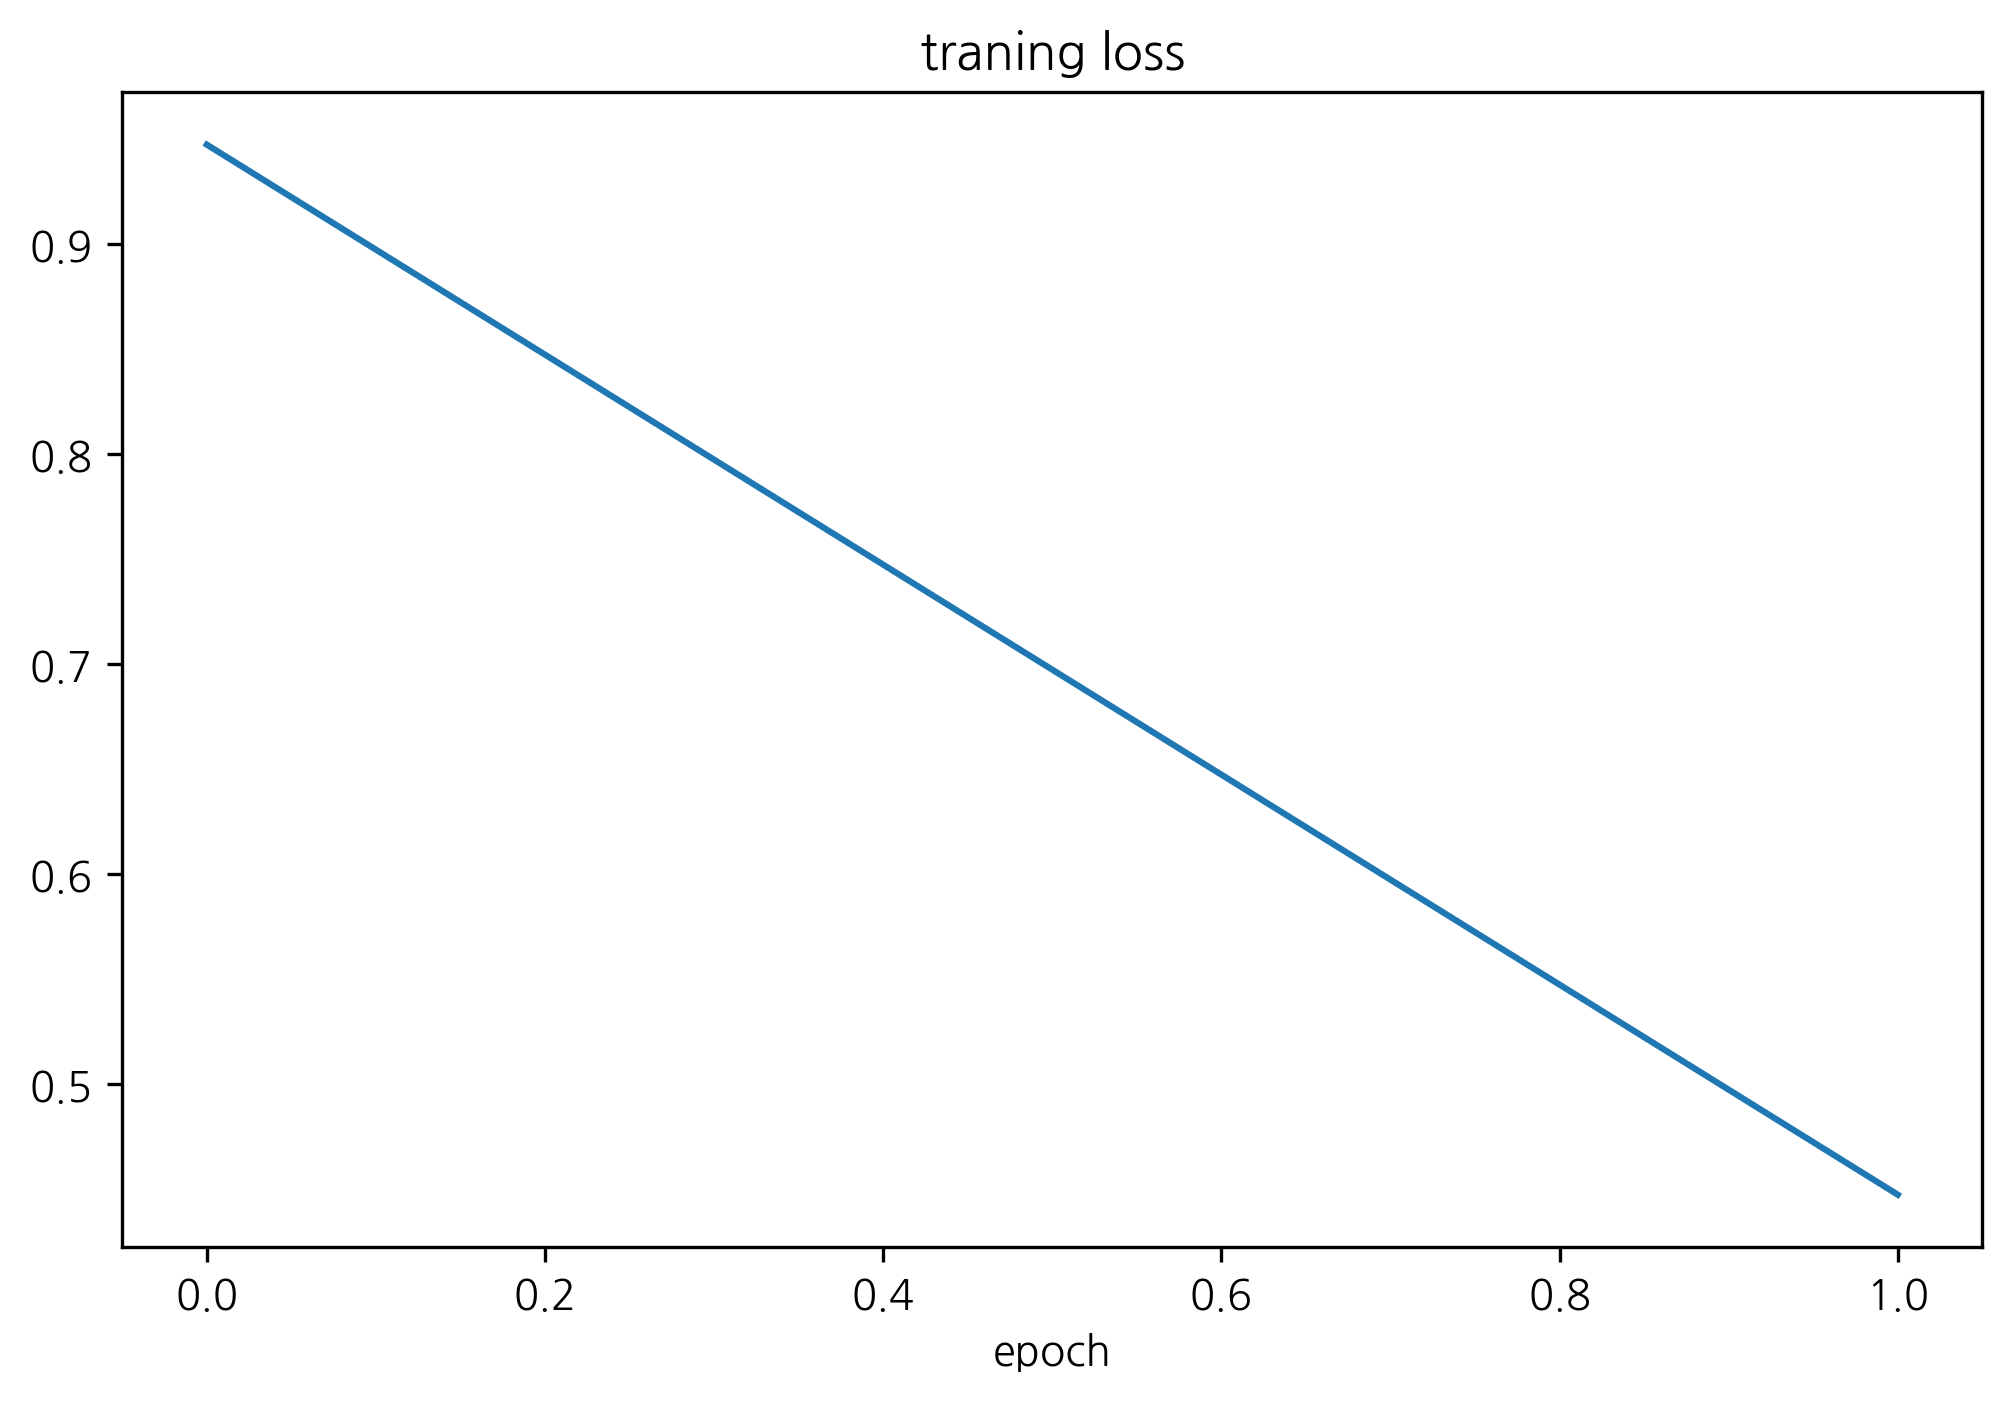

In [8]:
# 그래프 작성 loss per epoch
plt.plot(loss_)
plt.title("traning loss")
plt.xlabel("epoch")
plt.show()

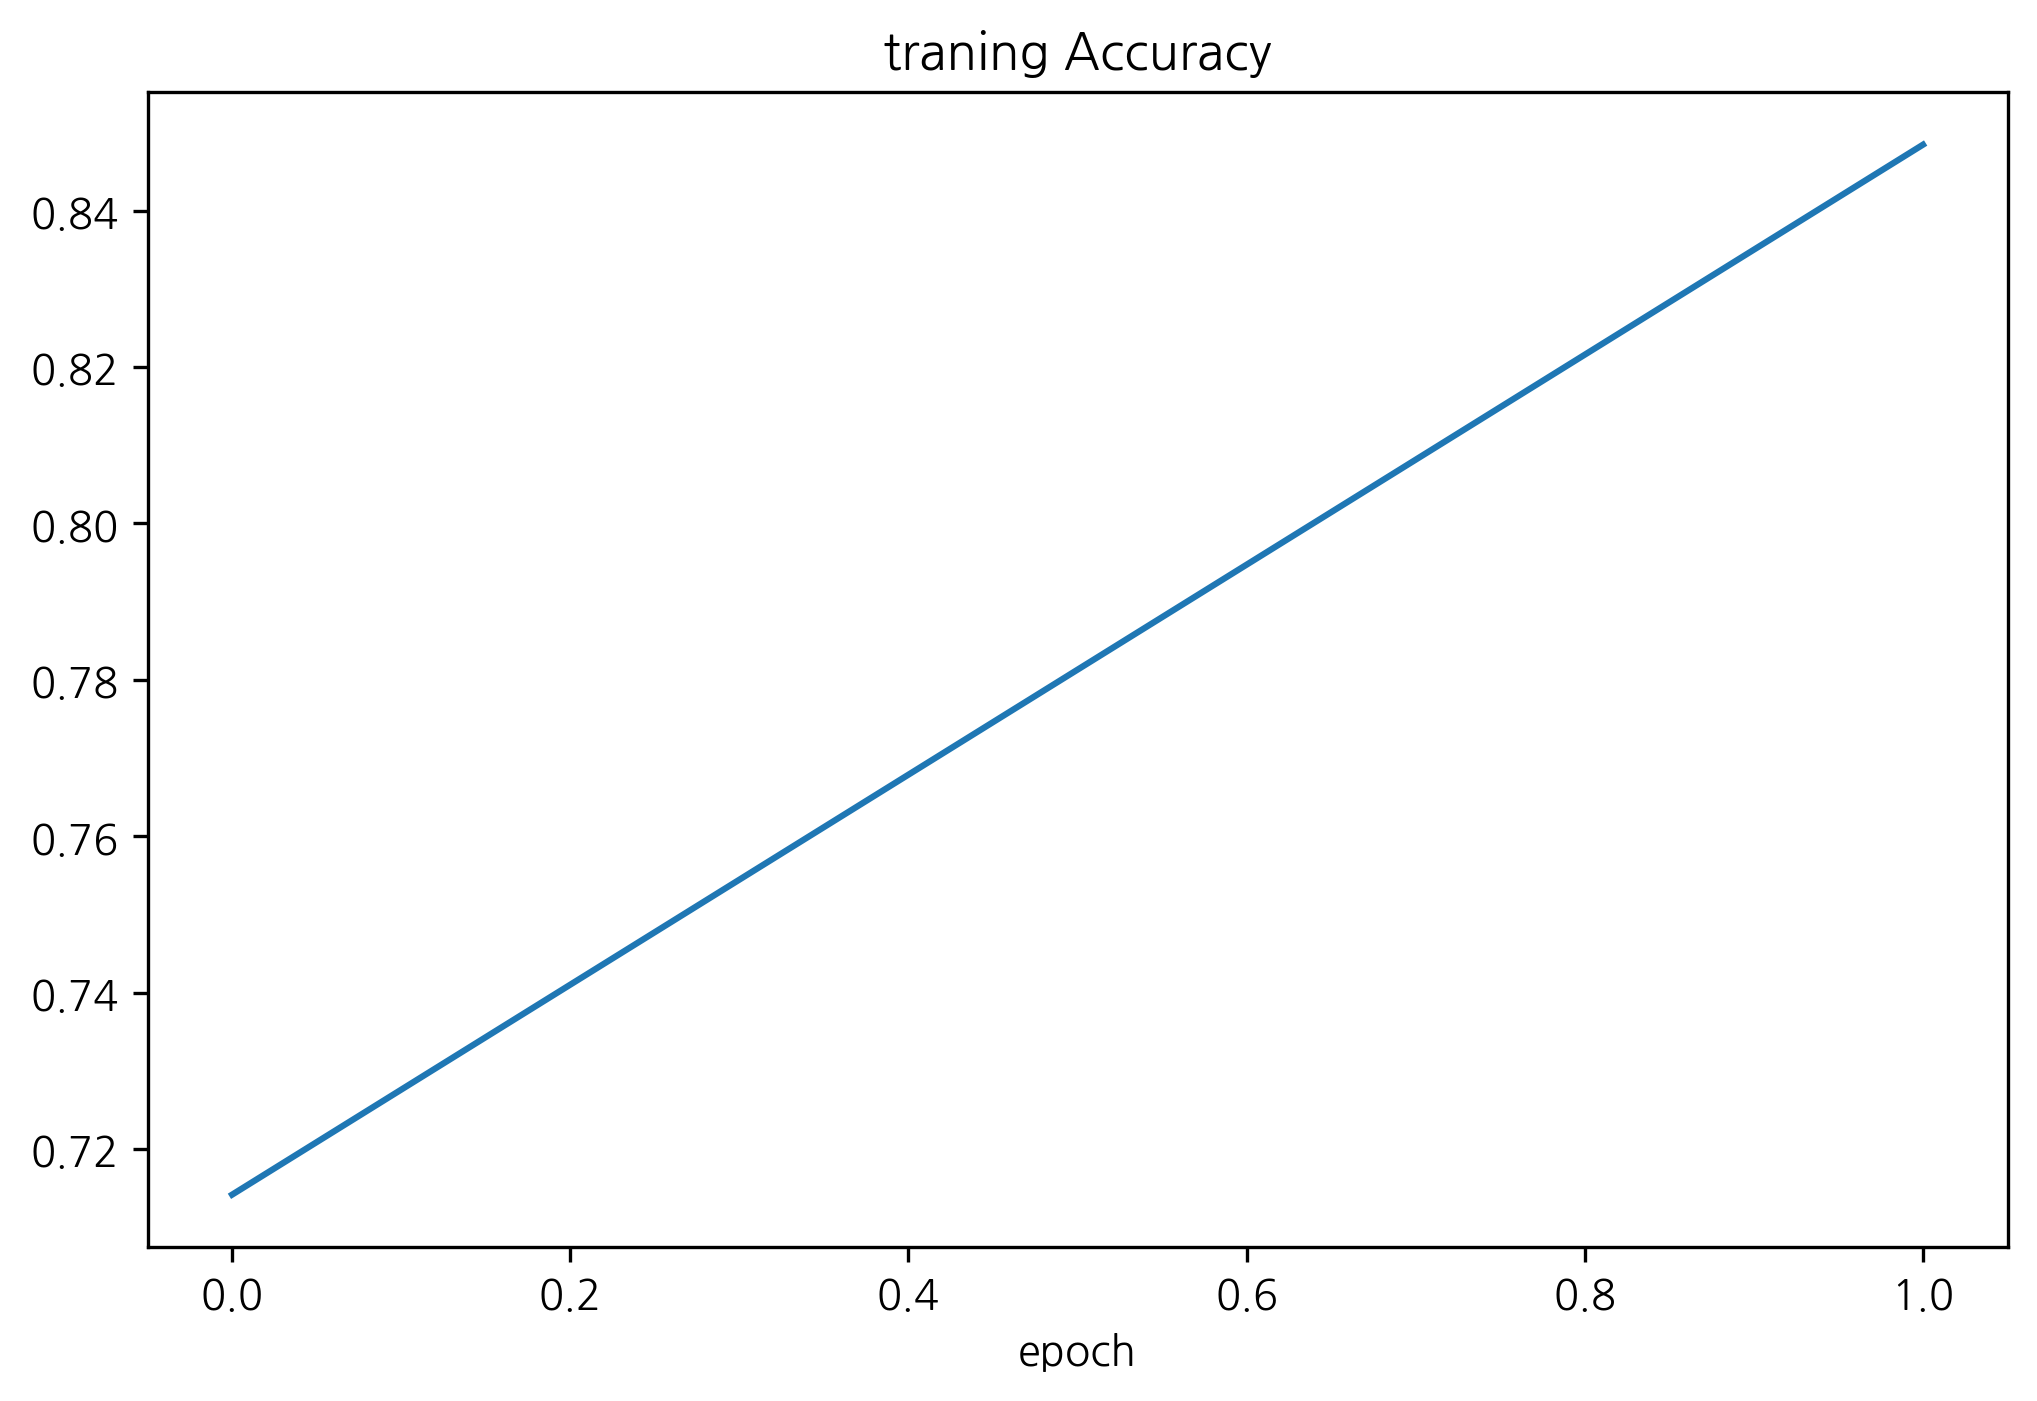

In [9]:
# 그래프 작성 accuracy per epoch
plt.plot(accus)
plt.title("traning Accuracy")
plt.xlabel("epoch")
plt.show()

In [ ]:
# 학습한 모델 저장
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
# 5. 시험용 데이터로 신경망 검사하기

testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False,
                                       download=True, 
                                       transform=transform)

testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=batch_size, 
                                         shuffle=False, 
                                         num_workers=4)

dataiter = iter(testloader)
images, labels = next(dataiter)

In [ ]:
# # 이미지를 출력합니다.
# imshow(torchvision.utils.make_grid(images))
# print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
# 저장했던 모델 불러오기
PATH = './cifar_net.pth'

model = torchvision.models.resnet50(pretrained = True)
model.load_state_dict(torch.load(PATH))

In [ ]:
# # 시험용 데이터 불러오기

# dataiter = iter(testloader)
# images, labels = next(dataiter)

model = torchvision.models.resnet50(pretrained = True)
model.load_state_dict(torch.load(PATH))
model.eval()

# f1-score 측정(no Gradients)
with torch.no_grad():
    y_true = []
    y_pred = []
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predictions.cpu().numpy())

f1 = f1_score(y_true, y_pred, average='macro')
print(f'F1 score: {f1:.3f}')

In [ ]:
# 전체 정확도 산출
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct // total} %')

In [ ]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}


with torch.`no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

---
# 결과 기록

- 하이퍼파라미터: 모델 학습 시 사람이 정해줘야하는 설정 값/함수 (위 코드에서 주의깊게 봐야할 사항)
    - Loss : 모델 예측값과 정답의 오차
    - Optimizer : 모델 학습 결과를 업데이트하는 방법
    - Learning Rate : 학습률. 모델 업데이트 시 반영할 비율
    - Epoch : 반복 학습 횟수
    - Batch_size : 학습 데이터를 분할하여 학습할 때 몇 개씩 할건지 정의
    
    
batch size : 64
optimizer : SGD
learning rate :  0.01
epoch : 50


1) early stopping 적용(patience 3 per loss) :  
    loss : [50] loss: 1.394
    ```
    Accuracy for class: plane is 48.0 %
    Accuracy for class: car   is 75.0 %
    Accuracy for class: bird  is 23.0 %
    Accuracy for class: cat   is 22.1 %
    Accuracy for class: deer  is 13.0 %
    Accuracy for class: dog   is 34.5 %
    Accuracy for class: frog  is 66.6 %
    Accuracy for class: horse is 66.6 %
    Accuracy for class: ship  is 51.3 %
    Accuracy for class: truck is 27.3 %
    ```
2) 미적용 :  
    loss : [50,   600] loss: 0.010  
    ```
    Accuracy for class: plane is 82.9 %
    Accuracy for class: car   is 85.0 %
    Accuracy for class: bird  is 69.9 %
    Accuracy for class: cat   is 61.4 %
    Accuracy for class: deer  is 79.4 %
    Accuracy for class: dog   is 59.6 %
    Accuracy for class: frog  is 87.5 %
    Accuracy for class: horse is 82.2 %
    Accuracy for class: ship  is 86.7 %
    Accuracy for class: truck is 83.3 %
    ```
    
    

batch size : 64  
optimizer : Adam()  
learning rate :  0.01  
epoch : 50  
```
loss : [50,   600] loss: 0.055
Accuracy for class: plane is 80.4 %
Accuracy for class: car   is 85.1 %
Accuracy for class: bird  is 58.1 %
Accuracy for class: cat   is 58.3 %
Accuracy for class: deer  is 76.0 %
Accuracy for class: dog   is 64.6 %
Accuracy for class: frog  is 84.4 %
Accuracy for class: horse is 83.6 %
Accuracy for class: ship  is 87.2 %
Accuracy for class: truck is 84.6 %
```

## resource

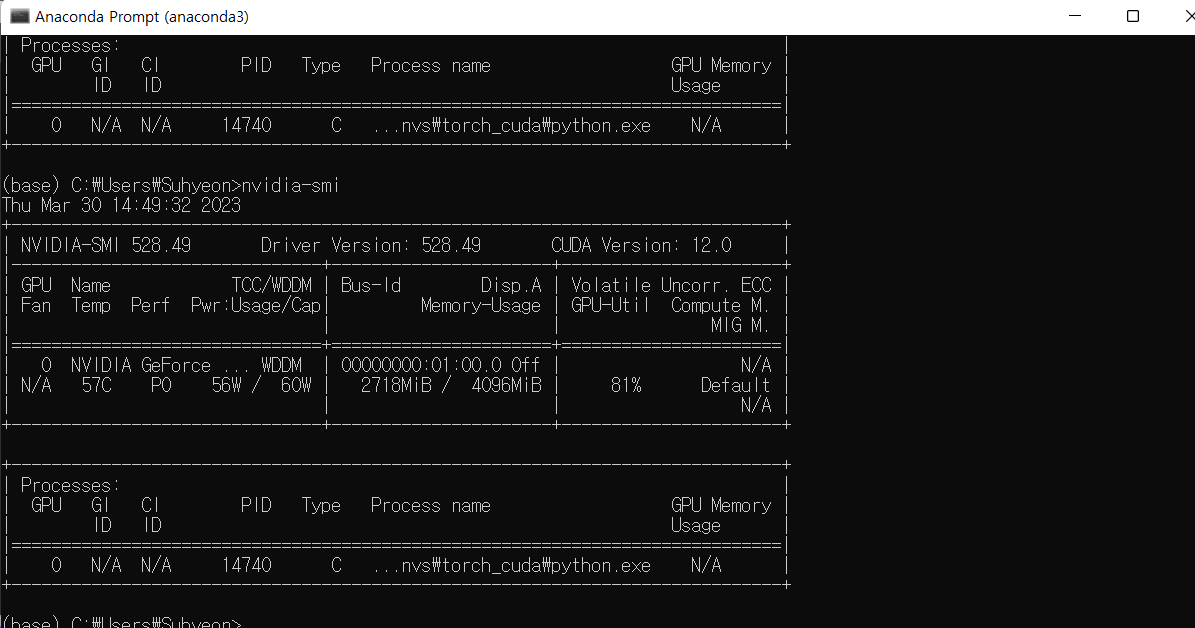